# Imports

In [44]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from src.data.tiny_imagenet_dataset import SmallImageNetTrainDataset

# Data

In [45]:
image_size = 256

In [46]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [47]:
sample = dataset[10000]
image = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [48]:
image.shape, label

(torch.Size([3, 256, 256]), 100)

In [49]:
# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# image, label = train_dataset[0]
# label

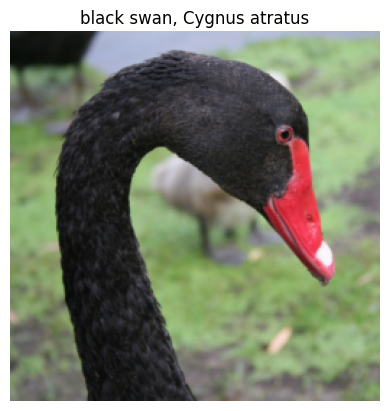

In [50]:
plt.title(f"{dataset.classes_names[image_tag]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)

# SVD

In [51]:
image.shape

torch.Size([3, 256, 256])

In [52]:
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 256, 256])

In [53]:
from src.tokenizers.svd_tokenizer import SVDLinearTokenizer

In [54]:
img_batch = torch.cat([image] * 32, dim=0)

In [55]:
tokenizer = SVDLinearTokenizer(image_size=image_size, num_channels=3, embedding_dim=768, dispersion=0.990, full_matrices=False)

In [56]:
approx_U, approx_S, approx_V, rank = tokenizer.get_approx_svd(image[0])

In [57]:
rank

160

In [58]:
reconstructed_image = tokenizer.reconstruct_image(approx_U, approx_S, approx_V)
reconstructed_image.shape

torch.Size([3, 256, 256])

In [59]:
# rank = 50
# 
# approx_image_channels = []
# for image_channel in image:
#     U, S, Vh = torch.linalg.svd(image_channel)
#     approx_image_channel = (U[:, :rank] @ torch.diag(S[:rank]) @ Vh[:rank, :])
#     approx_image_channels.append(approx_image_channel)
#     
# approx_image = torch.stack(approx_image_channels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023268068..1.0013087].


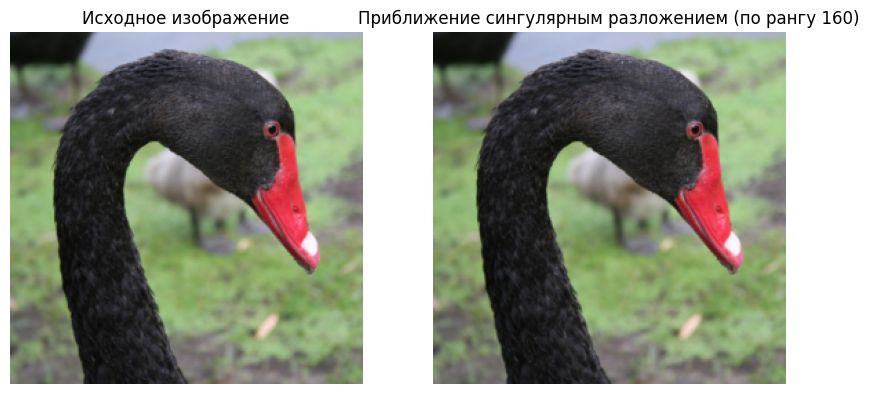

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image[0].permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[0].set_title("Исходное изображение")
axes[0].axis("off")

axes[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[1].set_title(f"Приближение сингулярным разложением (по рангу {rank})")
axes[1].axis("off")

plt.show()

## Tokenization

In [61]:
img_batch.shape

torch.Size([32, 3, 256, 256])

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
tokenizer = tokenizer.to(device)
img_batch = img_batch.to(device)

In [64]:
embedding = tokenizer(img_batch)

In [65]:
embedding.shape

torch.Size([32, 161, 768])

# SVD dispersion

In [66]:
image.shape

torch.Size([1, 3, 256, 256])

In [67]:
U, S, Vh = torch.linalg.svd(image[0], full_matrices=True)
Vh = Vh.mH

## Linear

In [68]:
S_sum = S.sum(dim=0, keepdim=True)

S_cumsum = torch.cumsum(S_sum, dim=1)
total_sum = S_sum.sum()

S_cumsum_norm = S_cumsum / total_sum

In [69]:
S_cumsum_norm_lin = S_cumsum_norm.squeeze().numpy()

## Quadratic

In [70]:
S_squared = torch.square(S)
S_squared = S_squared.sum(dim=0, keepdim=True)

S_cumsum = torch.cumsum(S_squared, dim=1)
total_sum = S_squared.sum()

S_cumsum_norm = S_cumsum / total_sum

In [71]:
S_cumsum_norm_quad = S_cumsum_norm.squeeze().numpy()

Text(0.5, 1.0, 'Зависимость сохранения доли информации от ранга приближения')

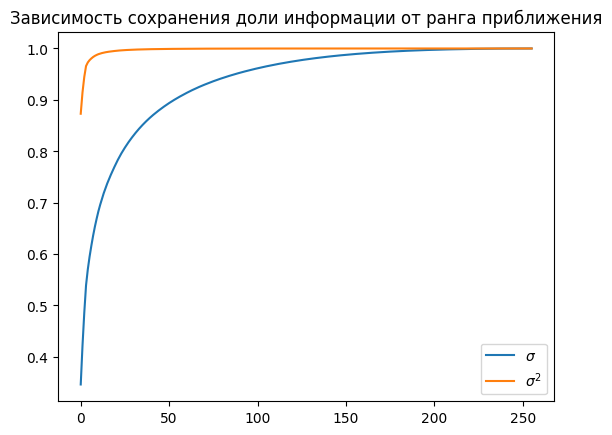

In [87]:
plt.plot(S_cumsum_norm_lin, label="$\sigma$")
plt.plot(S_cumsum_norm_quad, label="$\sigma^2$")
plt.legend()
plt.title("Зависимость сохранения доли информации от ранга приближения")

# Check random transforms

In [73]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [74]:
sample = dataset[10000]
image_base = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [75]:
random_transform = transforms.Compose([
        transforms.Resize((
            int(image_size * 1.25),
            int(image_size * 1.25)
        )),
        transforms.RandomCrop(image_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(
        #     mean=[0.485, 0.456, 0.406],
        #     std=[0.229, 0.224, 0.225]
        # ),
])

dataset_aug = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=random_transform
)

In [76]:
sample_aug = dataset_aug[10000]
image_aug = sample_aug["image"]
label_aug = sample_aug["label_encoded"]
image_tag_aug = sample_aug["tag"]

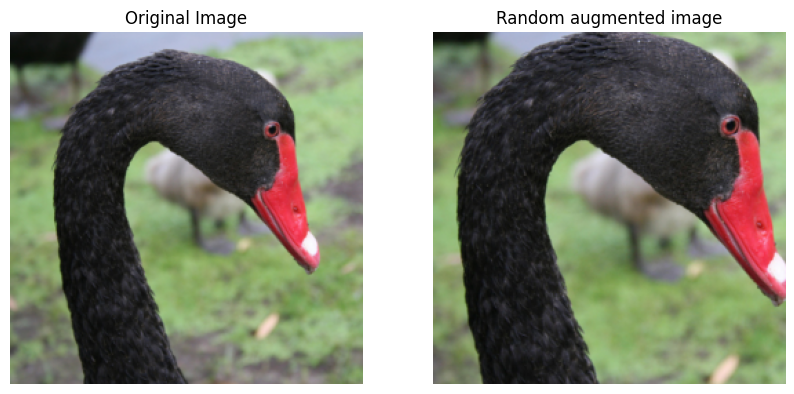

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_base.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image_base.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(image_aug.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image_aug.shape[0] == 1 else None)
axes[1].set_title(f"Random augmented image")
axes[1].axis("off")

plt.show()

In [78]:
approx_U_base, approx_S_base, approx_V_base, rank_base = tokenizer.get_approx_svd(image_base)
rank_base

160

In [79]:
approx_U_aug, approx_S_aug, approx_V_aug, rank_aug = tokenizer.get_approx_svd(image_aug)
rank_aug

171

In [80]:
n_channels, im_sz, rnk_base = approx_U_base.shape
approx_U_base = torch.reshape(approx_U_base, (n_channels * rnk_base, im_sz))
approx_U_base.shape

torch.Size([480, 256])

In [81]:
n_channels, im_sz, rnk_aug = approx_U_aug.shape
approx_U_aug = torch.reshape(approx_U_aug, (n_channels * rnk_aug, im_sz))
approx_U_aug.shape

torch.Size([513, 256])

In [82]:
cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

In [83]:
output_U = cos_sim(approx_U_base[0:min(rnk_base, rnk_aug)], approx_U_aug[0:min(rnk_base, rnk_aug)])
output_U.abs().sum() / output_U.shape[0]

tensor(0.0490)

In [84]:
n_channels, im_sz, rnk_base = approx_V_base.shape
approx_V_base = torch.reshape(approx_V_base, (n_channels * rnk_base, im_sz))
approx_V_base.shape

torch.Size([480, 256])

In [85]:
n_channels, im_sz, rnk_base = approx_V_aug.shape
approx_V_aug = torch.reshape(approx_V_aug, (n_channels * rnk_base, im_sz))
approx_V_aug.shape

torch.Size([513, 256])

In [86]:
output_V = cos_sim(approx_V_base[0:min(rnk_base, rnk_aug)], approx_V_aug[0:min(rnk_base, rnk_aug)])
output_V.abs().sum() / output_V.shape[0]

tensor(0.0522)